In [32]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import functools as ft
from scipy.linalg import expm
from sys import getsizeof
%load_ext line_profiler

In [377]:
#Gates

I = np.eye(2)
H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
 
def P(phi):
    #Phase gate
    return np.exp(1j*phi)*np.eye(2)

def Rx(theta):
    return expm(-1j*X*theta/2)
    
def Multi_gate(gate, k : int, n : int):
        """
        gate: Single_qubit_gate()
        k: gate qubit index
        n: total number of qubits
        """
        lst = [np.eye(2) if j != k else gate for j in range(n)]
        return ft.reduce(np.kron, lst) #Optimise this

def Multi_CNOT(k1 : int, k2 : int, n : int):
    """
    k1: control qubit index
    k2: target qubit index
    n: total number of qubits
    """
    cnot0 = np.array([[1,0],[0,0]])
    cnot1 = np.array([[0,0],[0,1]])
    cnotx = np.array([[0,1],[1,0]])
    
    lst1 = [np.eye(2) if j != k1 else cnot0  for j in range(n)]
    lst2 = [cnot1 if j == k1 else cnotx if j == k2 else np.eye(2) for j in range(n) ]
    return ft.reduce(np.kron,lst1) + ft.reduce(np.kron,lst2) #Optimise this 


#State class 
class State:
    def __init__(self, num_qubits :int, init_state = 0):
        """
        init_state: index of basis vector of the initial state
        """
        self.num_qubits = num_qubits
        self.basis = list(it.product(range(2), repeat=num_qubits))
        
        #Initialise the state in init_state
        self.tensor = np.zeros([2 for i in range(num_qubits)],dtype=complex)
        self.tdim = self.tensor.shape
        self.tdim_flat = 2**self.num_qubits
        self.tensor[self.basis[init_state]] = 1

    def apply_single_qubit_gate(self, gate, k :int):
        multigate = Multi_gate(gate, k, self.num_qubits)
        self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat)).reshape(self.tdim)

    def apply_cnot_qubit_gate(self, k1 : int, k2 : int):
        multigate = Multi_CNOT(k1,k2, self.num_qubits)
        self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat)).reshape(self.tdim)

    def conditional_measurement(self, k : int, proj: int):
        """
        k: qubit being measured
        proj: 0 or 1, state of projection
        
        """
        
        #Swap indices so k is the last qubit
        swapped = self.tensor.swapaxes(k, -1)
        self.tensor = swapped[..., proj] #Project last qubit into 0 or 1 state 

        #Calculate the probability
        norm  = np.sum(np.abs(self.tensor))**2
        if norm != 0:
            self.tensor /= norm #Normalise the tensor
        else:
            print(f'Probability of qubit {k} being {proj} is {norm}.')

        #Update properties of reduced state
        self.num_qubits = len(self.tensor)
        self.basis = list(it.product(range(2), repeat=self.num_qubits))
        self.tdim = self.tensor.shape
        self.tdim_flat = 2**self.num_qubits

    def plot_state(self):
        """
        Plot the probability of each basis vector
        """
        probs = np.abs(self.tensor)**2
                    
        plt.bar(range(self.tdim_flat), probs.reshape(self.tdim_flat))
        #plt.bar(range(num_basis_states) ,self.probabilities)

        labels = self.basis

        
        if self.num_qubits <= 4:
            plt.xticks(np.arange(2**self.num_qubits),self.basis, rotation = 90)
            plt.xlabel('Basis state')
        else:
            plt.xlabel('Basis number')
            
        plt.ylabel('Probability')
    

        
       

## Initialise the $\ket{000}$ state

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


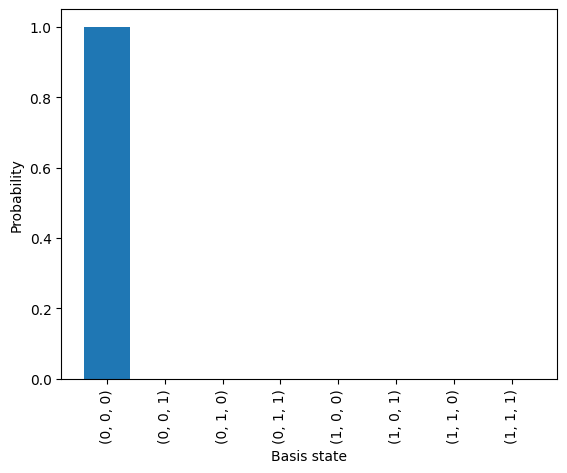

In [378]:
state = State(3)
print(state.basis)
state.plot_state()



## Apply some single mode gates 
(I always initialise the $\ket{000}$ state)

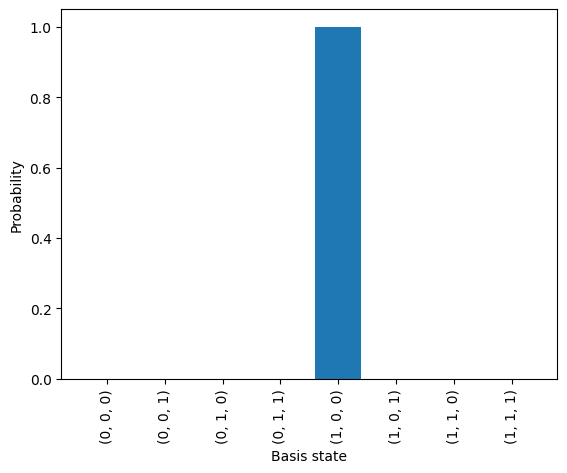

In [379]:
## Apply an X gate 
num = 3
state = State(num)
state.apply_single_qubit_gate(X, 0)
state.plot_state()


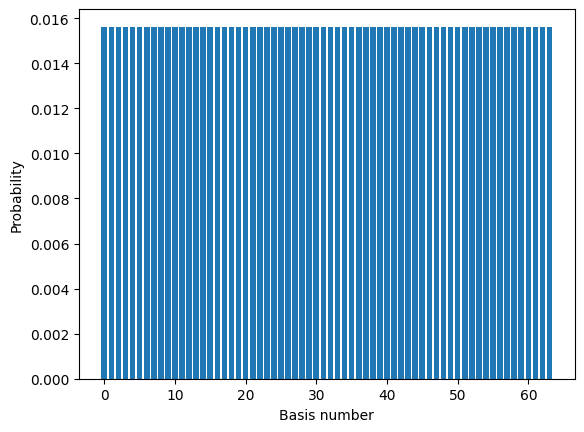

In [381]:
## Apply Hadamard gate on all qubits

num = 6

state = State(num, )

[state.apply_single_qubit_gate(H, i) for i in range(0,num)]
#state.apply_single_qubit_gate(Y_gate, 2)

state.plot_state()


## Initialise state $\ket{100}$

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


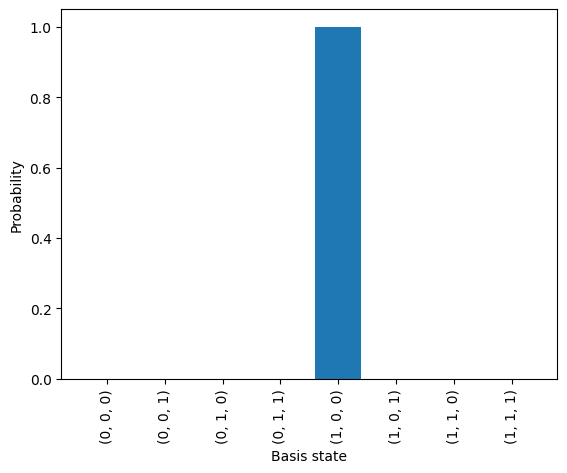

In [384]:
state = State(3, 4) #Initialise state in #100 
print(state.basis)
state.plot_state()

In [273]:
%%timeit
state = State(10)
#print(state.basis)
state.apply_single_qubit_gate(H, 0)
state.apply_cnot_qubit_gate(0,2)
state.apply_cnot_qubit_gate(2,4)
state.apply_cnot_qubit_gate(4,5)
#state.plot_state()

71.8 ms ± 6.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Profiling the code

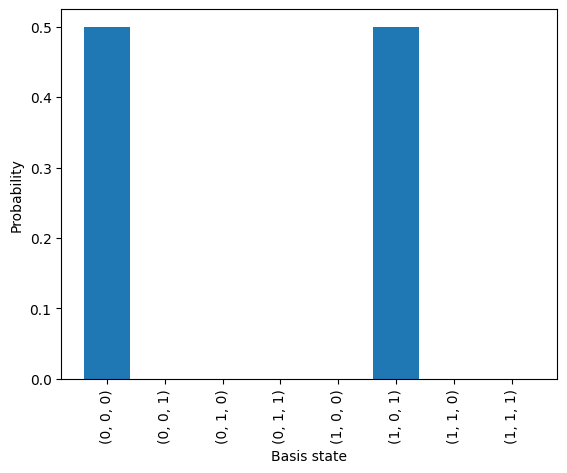

In [274]:
state = State(3)
#print(state.basis)
state.apply_single_qubit_gate(H_gate, 0)
state.apply_cnot_qubit_gate(0,2)
state.plot_state()

In [35]:
def test_calc(num):
    state = State(num)
    state.apply_single_qubit_gate(H, 0)
    state.apply_cnot_qubit_gate(0,2)
    return

In [37]:
%lprun -f test_calc test_calc(10)


Timer unit: 1e-09 s

Total time: 0.07047 s
File: /var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_63649/1325946024.py
Function: test_calc at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def test_calc(num):
     2         1     130000.0 130000.0      0.2      state = State(num)
     3         1   31443000.0    3e+07     44.6      state.apply_single_qubit_gate(H, 0)
     4         1   38897000.0    4e+07     55.2      state.apply_cnot_qubit_gate(0,2)
     5         1          0.0      0.0      0.0      return

In [40]:
%lprun -f state.apply_single_qubit_gate state.apply_single_qubit_gate(H,0)

Timer unit: 1e-09 s

Total time: 0.00068 s
File: /var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_63649/501870100.py
Function: apply_single_qubit_gate at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
    52                                               def apply_single_qubit_gate(self, gate, k):
    53         1     615000.0 615000.0     90.4          multigate = Multi_gate(gate, k, self.num_qubits)
    54         1      65000.0  65000.0      9.6          self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat)).reshape(self.tdim)

In [38]:
%lprun -f state.apply_cnot_qubit_gate state.apply_cnot_qubit_gate(0,2)

Timer unit: 1e-09 s

Total time: 0.000443 s
File: /var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_63649/501870100.py
Function: apply_cnot_qubit_gate at line 56

Line #      Hits         Time  Per Hit   % Time  Line Contents
    56                                               def apply_cnot_qubit_gate(self, k1,k2):
    57         1     416000.0 416000.0     93.9          multigate = Multi_CNOT(k1,k2, self.num_qubits)
    58         1      27000.0  27000.0      6.1          self.tensor = (multigate @ self.tensor.reshape(self.tdim_flat)).reshape(self.tdim)

In [42]:
%lprun -f Multi_CNOT Multi_CNOT(0,2,3)

Timer unit: 1e-09 s

Total time: 0.000793 s
File: /var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_63649/2203497099.py
Function: Multi_CNOT at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                           def Multi_CNOT(k1 : int, k2 : int, n : int):
    26                                               """
    27                                               k1: control qubit index
    28                                               k2: target qubit index
    29                                               n: total number of qubits
    30                                               """
    31         1      31000.0  31000.0      3.9      cnot0 = np.array([[1,0],[0,0]])
    32         1       6000.0   6000.0      0.8      cnot1 = np.array([[0,0],[0,1]])
    33         1       5000.0   5000.0      0.6      cnotx = np.array([[0,1],[1,0]])
    34                                               
    35         1      5600

## Measure a qubit

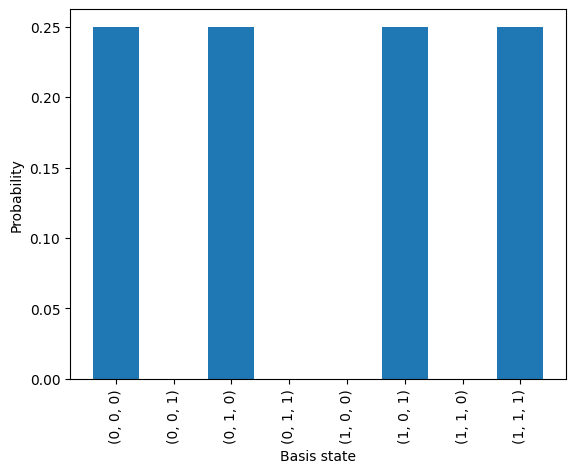

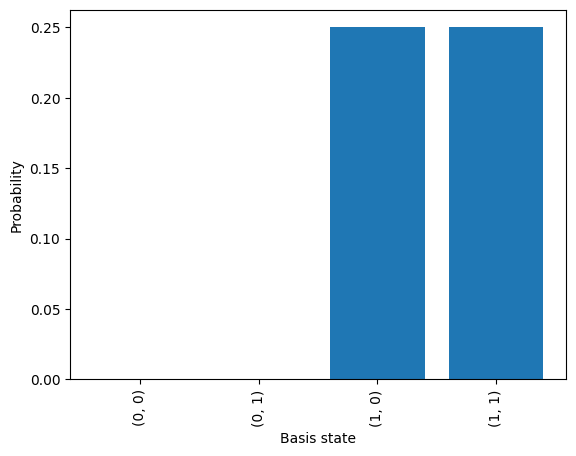

In [399]:
#Initial state
state = State(3)
state.apply_single_qubit_gate(H, 0)
state.apply_single_qubit_gate(H, 1)
state.apply_cnot_qubit_gate(0,2)
state.plot_state()
plt.show()


#Measure mode 0 to be 1
state.conditional_measurement(2,1)
state.plot_state()
